In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import random

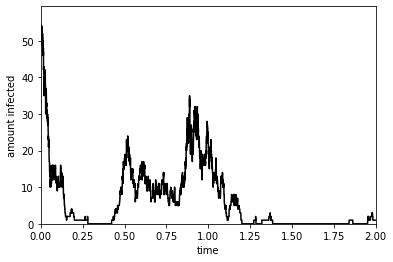

In [41]:
def time_plot(N, S, I, beta, gamma, mu=0, v=0, 
              ax=None, focus=None, time_lim=2, **plt_kwargs):
    
    R_0 = beta / (gamma+v)
    
    if ax is None:
        ax = plt.gca()

    X, Y, Z, t = GDA(N, S, I, beta, gamma, mu=mu, v=v, time_lim=time_lim)
    ax.plot(t, X, label='Susceptible', color='blue')
    ax.plot(t, Y, '-', label='Infected', color='black')
    ax.plot(t, Z, '-.', label='Recovered', color='grey')

    ax.set_xlabel('time')
    ax.set_xlim(0, max(t))
    
    if focus == 'susceptible':
        ax.set_ylim(0.9*min(X), 1.1*max(X))
        ax.set_ylabel('amount susceptible')
    elif focus == 'infected':
        ax.set_ylim(0.9*min(Y), 1.1*max(Y))
        ax.set_ylabel('amount infected')
    elif focus == 'recovered':
        ax.set_ylim(0.9*min(Z), 1.1*max(Z))
        ax.set_ylabel('amount recovered')
    else:
        ax.set_ylim(0, max([max(X), max(Y), max(Z)]))
        ax.set_ylabel('amount of individuals')
    return ax

def SIR_rates(N, X, Y, beta, gamma, mu=0, v=0):
    '''
    Determines rates of events
    '''
    R_0 = beta  / (gamma+v)
    epsilon = 1.06*mu*(R_0-1)/np.sqrt(N)
    Z = N-(X+Y)
    return [v*N, beta*X*Y/N, gamma*Y, mu*X, mu*Y, mu*Z, 0.0625*mu*(R_0-1)*np.sqrt(N), epsilon*X]


def GDA(N, S, I, beta, gamma, mu=0, v=0, time_lim=2, scale=False, steps=False):
    '''
    Gillespie's Direct Algorithm
    
    Inputs:
    N: int, total population size
    S: float, fraction of susceptibles of N
    I: float, fraction of infected of N
    beta, gamma, mu, v, delta: transmission rate, recovery rate, death rate, birth rate, import rate
    steps: int, number of times gillespie's algorithm is executed
    
    Returns:
    X, Y, Z: lists with absolute amount of susceptible, infected and recovered individuals
    t: list with the time intervals at which events occured
    '''
    
    # initial values
    X = [S*N]
    Y = [I*N]
    Z = [N * (1-(S+I))]
    N = [N]
    time = [0]

    # which rate index corresponds to which dX, dY, dZ
    changes = {0:[1, 0, 0], 1:[-1, 1, 0], 2:[0, -1, 1], 3:[-1, 0, 0],
               4:[0, -1, 0], 5:[0, 0, -1], 6:None, 7:[-1, 1, 0]}
    
    if not steps:
        while True:
            rates = [0] + SIR_rates(N[-1], X[-1], Y[-1], beta, gamma,
                                    mu=mu, v=v)

            R_total = sum(rates)

            # time step size
            dt = -1/R_total * np.log(np.random.random())
            P = np.random.random() * R_total

            dX, dY, dZ = 0, 0, 0
            for j in range(1, len(rates)+1):
                if sum(rates[:j]) < P <= sum(rates[:j+1]):
                    if j == 7:
                        imports = random.choices([[-1, 1, 0], [0, 1, -1]], weights=[X[-1], Z[-1]])[0]
                        dX += imports[0]
                        dY += imports[1]
                        dZ += imports[2]
                    else:
                        dX += changes[j-1][0]
                        dY += changes[j-1][1]
                        dZ += changes[j-1][2]

            X += [X[-1] + dX]
            Y += [Y[-1] + dY]
            Z += [Z[-1] + dZ]
            N += [X[-1] + Y[-1] + Z[-1]]

            time += [time[-1]+dt]

            if time[-1] >= time_lim:
                if scale:
                    # returns XYZ as fractions
                    X = np.array(X)/np.array(N)
                    Y = np.array(Y)/np.array(N)
                    Z = np.array(Z)/np.array(N)

                return X, Y, Z, time
            
    else:
        for i in range(steps):
            # rates = [0, birth, transmission, recovery, death X, Y, Z]
            rates = [0] + SIR_rates(N[-1], X[-1], Y[-1], beta, gamma,
                                    mu=mu, v=v)

            R_total = sum(rates)

            # time step size
            dt = -1/R_total * np.log(np.random.random())
            P = np.random.random() * R_total

            dX, dY, dZ = 0, 0, 0
            for j in range(1, len(rates)+1):
                if sum(rates[:j]) < P <= sum(rates[:j+1]):
                    if j == 7:
                        imports = random.choices([[-1, 1, 0], [0, 1, -1]], weights=[X[-1], Z[-1]])[0]
                        dX += imports[0]
                        dY += imports[1]
                        dZ += imports[2]
                    else:
                        dX += changes[j-1][0]
                        dY += changes[j-1][1]
                        dZ += changes[j-1][2]

            X += [X[-1] + dX]
            Y += [Y[-1] + dY]
            Z += [Z[-1] + dZ]
            N += [X[-1] + Y[-1] + Z[-1]]

            time += [time[-1]+dt]

        if scale:
            # returns XYZ as fractions
            X = np.array(X)/np.array(N)
            Y = np.array(Y)/np.array(N)
            Z = np.array(Z)/np.array(N)

        return X, Y, Z, time

time_plot(1e5, 0.1, 5e-4, 520, 365.25/7, mu=1/70, v=1/70,
         focus='infected')
plt.show()

Extinction based on population size

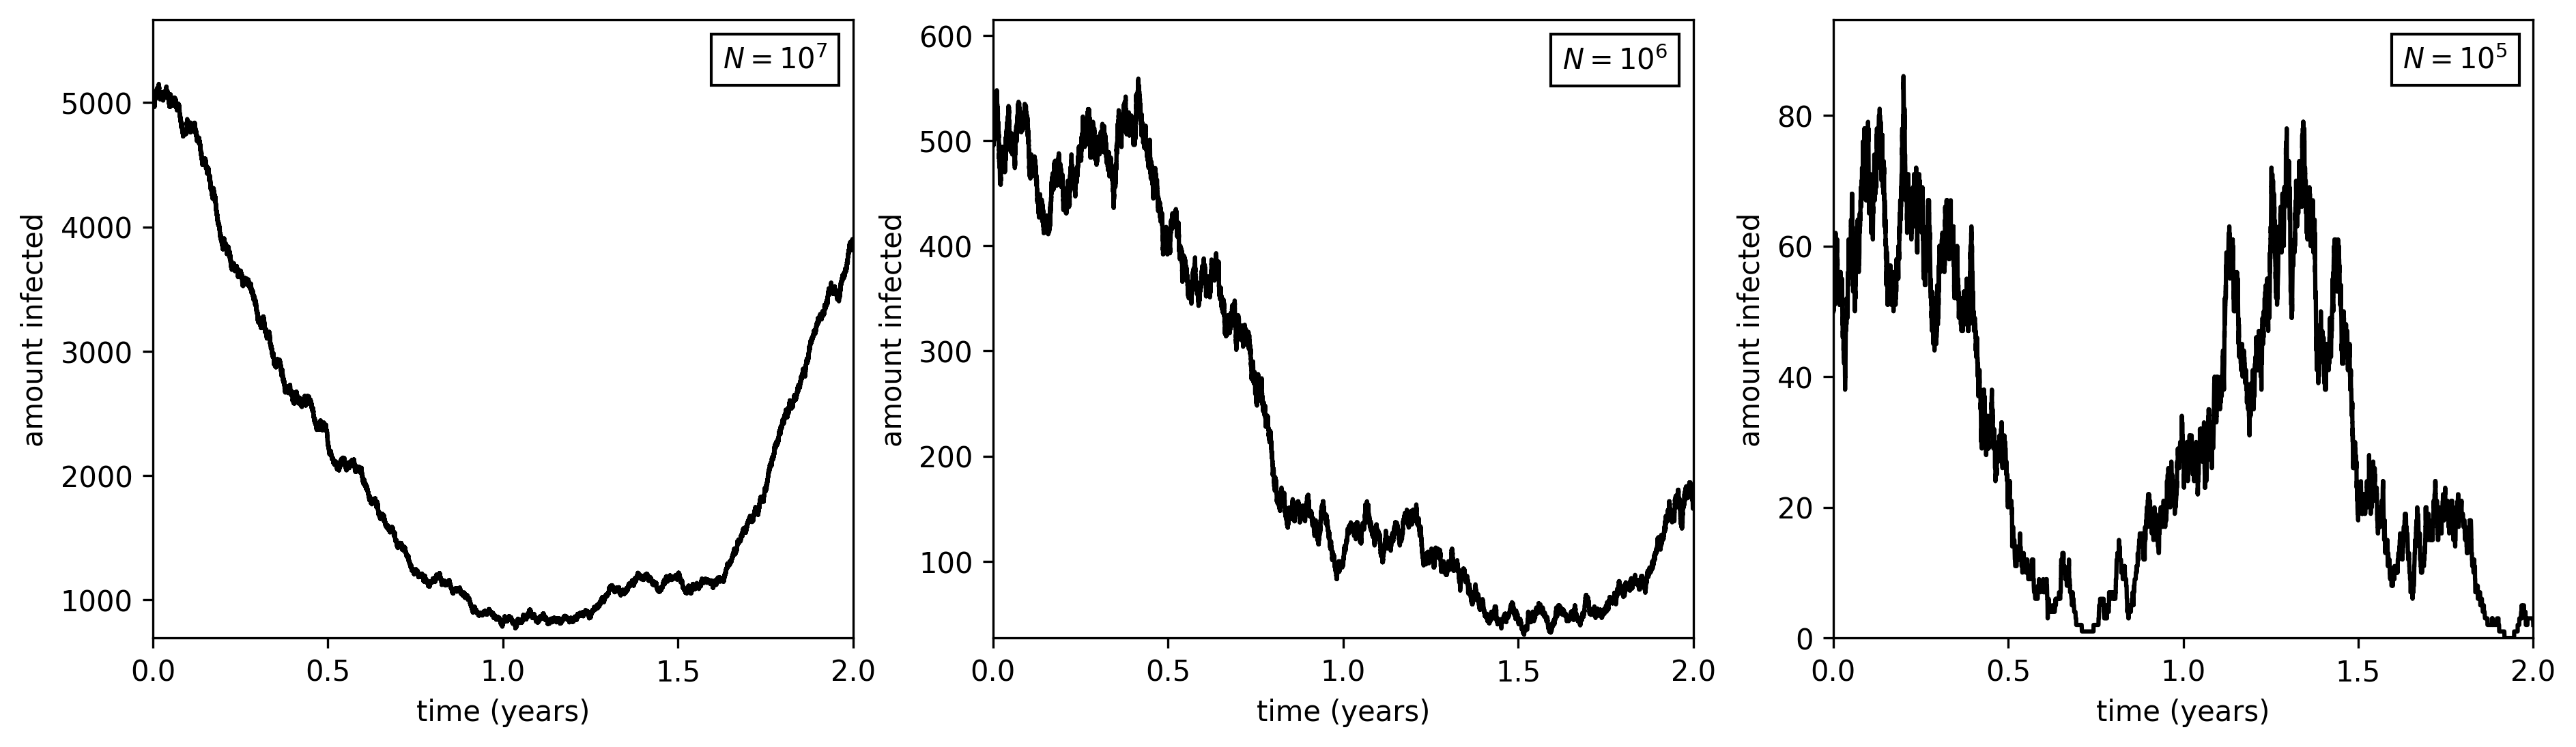

In [24]:
fig, [ax1, ax2, ax3]= plt.subplots(1, 3, figsize=(15, 4), dpi=300)

ax1 = time_plot(1e7, 0.1, 5e-4, 520, 365.25/7, mu=1/70, v=1/70,
        focus='infected', ax=ax1)
anchored_text = AnchoredText(rf'$N = 10^7$', loc=1)
ax1.add_artist(anchored_text)
ax1.set_xlabel('time (years)')

ax2 = time_plot(1e6, 0.1, 5e-4, 520, 365.25/7, mu=1/70, v=1/70,
         focus='infected', ax=ax2)
anchored_text = AnchoredText(rf'$N = 10^6$', loc=1)
ax2.add_artist(anchored_text)
ax2.set_xlabel('time (years)')

ax3 = time_plot(1e5, 0.1, 5e-4, 520, 365.25/7, mu=1/70, v=1/70,
         focus='infected', ax=ax3)
anchored_text = AnchoredText(rf'$N = 10^5$', loc=1)
ax3.add_artist(anchored_text)
ax3.set_xlabel('time (years)')

plt.savefig('popsize_extinctions.png', dpi=300)
plt.show()

In [54]:
pop_size = np.linspace(10**5, 10**6, 100, dtype=int)
gamma = 36.5
mu = 5.5e-5 * 365.25
beta = 10*(gamma+mu)
S0 = 0.1
I0 = 5e-4

all_Y = []
avg_ext = []
for N in pop_size:
    num_ext = []
    for i in range(2):
        X, Y, Z, t = GDA(N, S0, I0, beta, gamma, mu=mu, v=mu, time_lim=1)
        num_ext += [len([y for y in Y if y==0])]
    all_Y += [Y]
    avg_ext += [np.mean(num_ext)]

In [56]:
print(avg_ext)

[165.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Variations plotted as the mean and the standard deviations

In [48]:
N = 1e6
S = 0.1
I = 2.5e-4
beta = 520
gamma = 365.25/7
mu = 1/70

all_X, all_Y, all_Z, all_t = [], [], [], []

for i in range(10):
    X, Y, Z, t = GDA(N, S, I, beta, gamma, mu=mu, v=mu, steps=int(1e5))
    all_X += [X]
    all_Y += [Y]
    all_Z += [Z]
    all_t += [t]

# transform list to 2d array
all_X = np.array(all_X)
all_Y = np.array(all_Y)
all_Z = np.array(all_Z)
all_t = np.array(all_t)

# calculate the mean of each column
X_mean = np.mean(all_X, axis=0)
Y_mean = np.mean(all_Y, axis=0)
Z_mean = np.mean(all_Z, axis=0)
t_mean = np.mean(all_t, axis=0)

# calculate the variance along each column
X_var = np.var(all_X, axis=0)
Y_var = np.var(all_Y, axis=0)
Z_var = np.var(all_Z, axis=0)

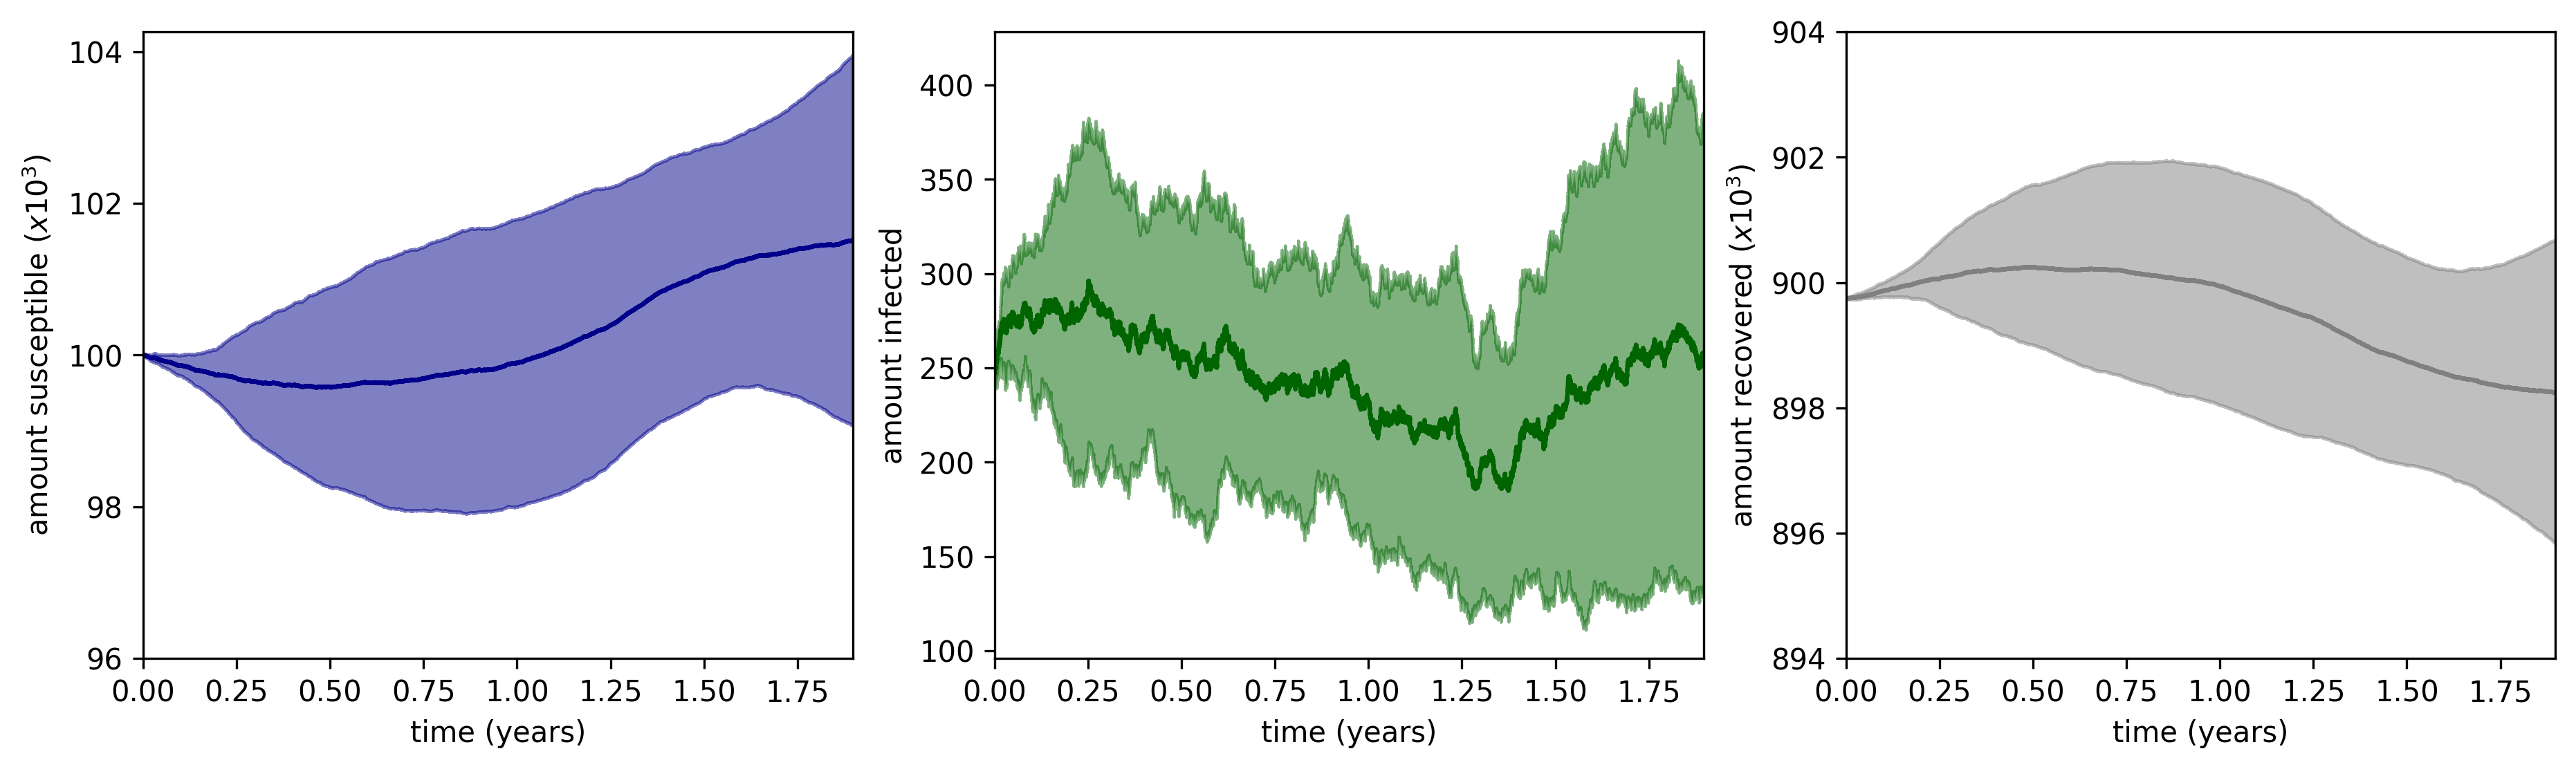

In [50]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(15, 4), dpi=300)

ax1.plot(t_mean, X_mean, color='darkblue')
ax1.fill_between(t_mean, X_mean-np.std(all_X, axis=0), X_mean+np.std(all_X, axis=0), color='darkblue', alpha=0.5)
ax1.set_xlabel('time (years)')
ax1.set_ylabel('amount susceptible $(x10^3)$')
ax1.set_yticks(np.arange(96000, 104001, 2000))
ax1.set_yticklabels(['96', 98, '100', 102, '104'])
ax1.set_xlim(0, max(t_mean))

ax2.plot(t_mean, Y_mean, color='darkgreen', label='infected')
ax2.fill_between(t_mean, Y_mean-np.std(all_Y, axis=0), Y_mean+np.std(all_Y, axis=0), color='darkgreen', alpha=0.5)
ax2.set_xlabel('time (years)')
ax2.set_ylabel('amount infected')
ax2.set_xlim(0, max(t_mean))

ax3.plot(t_mean, Z_mean, color='grey', label='recovered')
ax3.fill_between(t_mean, Z_mean-np.std(all_Z, axis=0), Z_mean+np.std(all_X, axis=0), color='grey', alpha=0.5)
ax3.set_yticks(np.arange(894000, 904001, 2000))
ax3.set_yticklabels([894, 896, 898, 900, 902, 904])
ax3.set_ylabel('amount recovered $(x10^3)$')
ax3.set_xlabel('time (years)')
ax3.set_xlim(0, max(t_mean))

plt.savefig('devations_GDA.png', dpi=300)
plt.show()

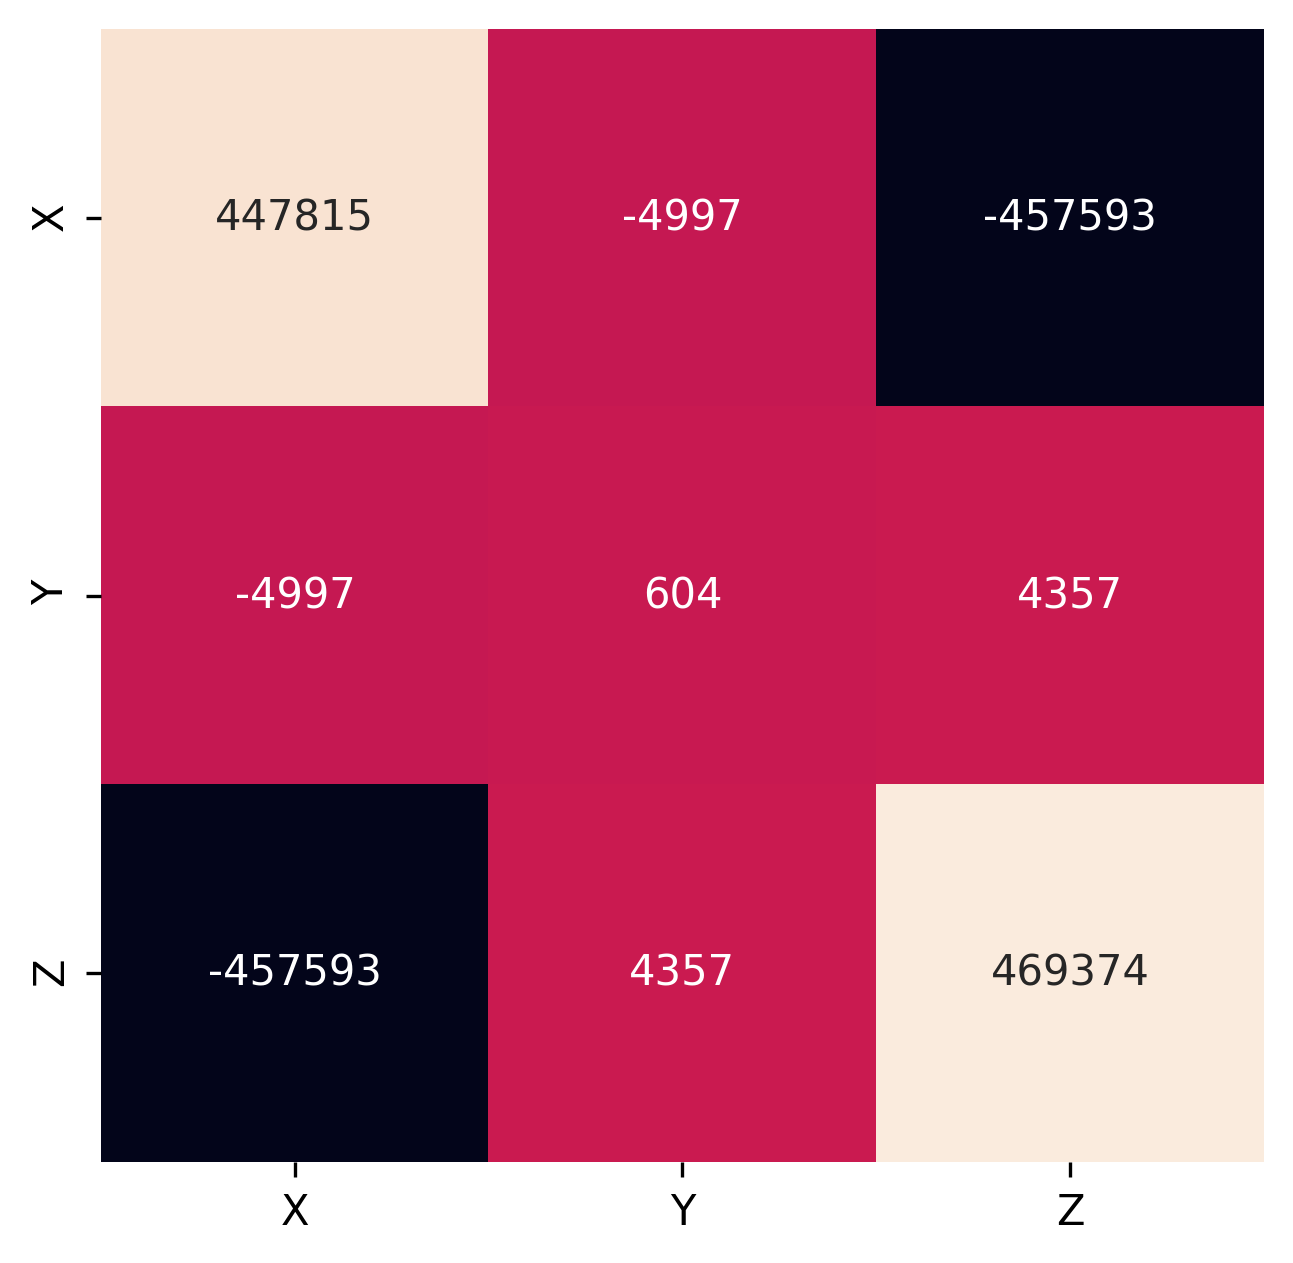

In [55]:
cov_SI = np.cov([X_mean, Y_mean, Z_mean])
cov_SI = np.array(cov_SI, dtype=int)

ylabels = ['X', 'Y', 'Z']
xlabels = ['susceptible', 'infected', 'recovered']

fig = plt.figure(figsize=(5, 5), dpi=300)
sns.heatmap(cov_SI, annot=True, fmt='g', xticklabels=ylabels, yticklabels=ylabels,
            cbar=False)
plt.savefig('cov_matrix.png', dpi=300)
plt.show()